<a href="https://colab.research.google.com/github/fi-co/py-CL-final-project/blob/main/Copia_di_BERTtopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Link to BERTopic original article](https://arxiv.org/pdf/2203.05794.pdf)

[Link to the dataset](https://https://www.kaggle.com/datasets/johoetter/design-thinking-arxiv/data)

[Link to the file](https://drive.google.com/drive/folders/1YL2I2S4tvPfB7qsO6lGHAWi1ahBQt8QR?usp=sharing) (to be donwloaded and re-uploaded on the local directory, here on colab)

# Main

## Initialize model and clustering

We are going to use BERTopic for topic modelling, so let's `pip install` the corresponding library:

In [ ]:
#Install the BERTopic library for topic modeling
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 15.2 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.7 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039295 sha256=292be8ead4cc9b8ff0361d85d4c25d72cf083b9e275694083c578d974a7f87ac
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
  Created wheel for umap-

Now let's istall most of the libraries we will work with in the next steps:

In [ ]:
import pandas as pd #Import pandas library for data manipulation (optional)

import numpy as np #Import numpy library for numerical operations

from bertopic import BERTopic #Import BERTopic library for topic modeling

from sklearn.feature_extraction.text import CountVectorizer #Import CountVectorizer from scikit-learn for text vectorization

import re #Import regular expression library for text preprocessing

#Import NLTK libraries for natural language processing tasks
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #Import english stopwords from scikit-learn for text preprocessing

import hashlib #Import hashlib library for generating unique IDs

import matplotlib.pyplot as plt #Import matplot library for data visualization

The next cell loads the original dataset containing information about arXiv papers from a CSV file named `'arxiv_papers.csv'`. It then creates a new DataFrame with only essential columns (we don't need all the information in the original Dataset).

In [ ]:
# Load the original dataset
data = pd.read_csv('arxiv_papers.csv')

# Create a new DataFrame with essential columns
essential_columns = ['title', 'abstract', 'published']

# Add a new column 'unique_ID' with ad-hoc unique identifiers
data['unique_ID'] = range(1, len(data) + 1)

# Reorder columns for the new DataFrame
essential_data = data[['unique_ID'] + essential_columns]

# Save the DataFrame to a new CSV file
essential_data.to_csv('modified_df.csv', index=False)


The next cell demonstrates the process of topic modelling using BERTopic on the modified DataFrame of arXiv papers using the abstracts.
The data is preprocessed to clean and tokenize the abstracts before vectorization. Then BERTopic pipeline is run and the result is saved in the local directory.


In [ ]:
#Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

#Define functions for preprocessing
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

def remove_stopwords(text):
    stop_words = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_text)

def stem_text(text):
    ps = PorterStemmer()
    words = word_tokenize(text)
    stemmed_text = [ps.stem(word) for word in words]
    return ' '.join(stemmed_text)

#Define a function to get unique IDs for each abstract
def generate_unique_id(title, published):
    unique_string = f"{title}{published}" # Combine title and puslished date to create a unique string
    unique_id = hashlib.sha256(unique_string.encode()).hexdigest()[:10] # Use hashlib to create unique ID
    return unique_id

#Load the DataFrame
data = pd.read_csv('modified_df.csv')

#Set the number of abstracts to use
num_abstracts = 2000 #We think 2000 abstracts is a good compromise between computational efficiency and meaningful results
data_subset = data.head(num_abstracts)

#Apply preprocessing
data_subset['abstract'] = data_subset['abstract'].str.lower()
data_subset['abstract'] = data_subset['abstract'].apply(clean_text)
data_subset['abstract'] = data_subset['abstract'].apply(remove_stopwords)
data_subset['abstract'] = data_subset['abstract'].apply(stem_text)

#Use CountVectorizer to get word frequencies
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data_subset['abstract']) #X is a matrix indicating word frequencies across abstracts

#Initialize BERTopic
bertopic = BERTopic()
topics, _ = bertopic.fit_transform(data_subset['abstract'])

#Obtain document vectors
document_vectors = bertopic.umap_model.embedding_

#Generate unique IDs for each document
data_subset['unique_ID'] = data_subset.apply(lambda row: generate_unique_id(row['title'], row['published']), axis=1)


#Save document vectors, clustering results, and document IDs in a new file
result_df = pd.DataFrame({
    'Document_ID': data_subset['unique_ID'],
    'Topic': topics,
    'Abstract': data_subset['abstract'],
    'Vectors': document_vectors.tolist()
})
result_df.to_csv('clustering_results.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

To extract meaningfull topics from each cluster, BERTopic leverages a class-based variation of TF-IDF.
Class-based TF-IDF (Term Frequency-Inverse Document Frequency) is a variant of the traditional TF-IDF weighti that takes into account the distribution of words across different classes(in this case, clusters of abstracts).

$W_{t,c} = \text{tf}_{t,c} \cdot \log \left(1 + \frac{A}{\text{tf}_{t}} \right)$

where:
- $\text{tf}_{t,c}$ is the term frequency of word $t$ in documents of category $c$
- $\text{tf}_{t}$ is the term frequency of word $t$ across all documents
- $A$ is the average number of words per class

Class-based TF-IDF offers a refined approach to weighting words in topic modelling tasks, enhancing the representation of document content by considering at the same time local and global term distributions within specific clusters of documents.


The next cell generates a bar plot to visualize the distribution of the Top-10 topics in the dataset (including outlier):

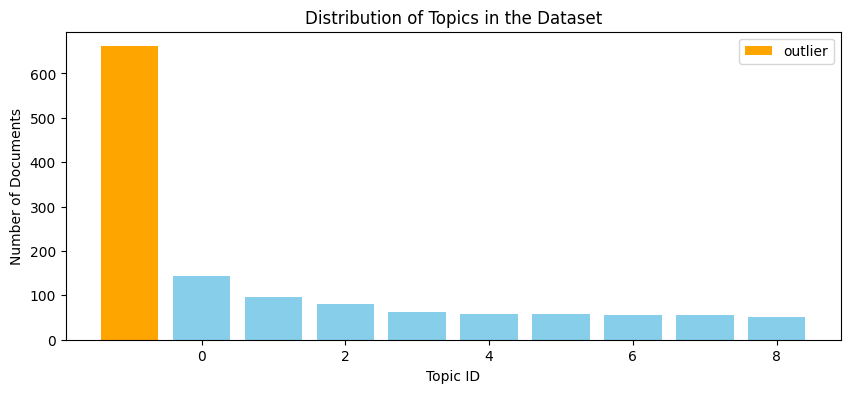

In [ ]:
#Visualize the distribution of topics
topic_counts = bertopic.get_topic_freq().sort_values(by='Count', ascending=False).head(10)
plt.figure(figsize=(10, 4))
plt.bar(topic_counts['Topic'], topic_counts['Count'], color='skyblue') #Plot the bar for top-10 topics

#Highlight outlier bar (topic -1)
outlier_topic_count = topic_counts[topic_counts['Topic'] == -1]
if not outlier_topic_count.empty:
    plt.bar(outlier_topic_count['Topic'], outlier_topic_count['Count'], color='orange', label='outlier')

plt.xlabel('Topic ID')
plt.ylabel('Number of Documents')
plt.title('Distribution of Topics in the Dataset')
plt.legend()
plt.show()

In topic modelling, an outlier topic represents documents that do not fit well any of the main topics identified by the model. This can occur due to various reasons such as noise in the data, documents covering diverse or unique topics, or documents with insufficient content to be clustered appropriately.

In the context of our job, we assume that dealing with AI research papaers, where topics are extremely nuanced and specialized, represents a likely reason for many documents to fall into the outlier category. Therefore, the presence of outliers reflect the inherent complexity and diversity of AI research, where topics not always align with predefined themes.

Later, we will dive deeper in the outlier.

The next couple cells provide a glimpse of how these topics looks like, qualitatively and quantitatively.

In [ ]:
#Output documents amount for the Top-10 topics
print("Topic Distribution:")
print(topic_counts)

Topic Distribution:
    Topic  Count
0      -1    661
1       0    143
2       1     97
20      2     80
16      3     62
6       4     59
18      5     58
17      6     55
4       7     55
11      8     52


In [ ]:
#Iterate through each topic and retrieve top-10 keyword
for topic_id in bertopic.get_topics():
    words = [word for word, _ in bertopic.get_topic(topic_id)]
    print(f"\nTop words for Topic {topic_id}: {', '.join(words)}")

#Let's create top_words_per_topic dictionary where keys are topic IDs and values are lists of keywords for each topic, we will need it later
top_words_per_topic = {}

#Iterate through the topics and store top words in the dictionary
for topic_id in bertopic.get_topics():
    words = [word for word, _ in bertopic.get_topic(topic_id)]
    top_words_per_topic[topic_id] = words


Top words for Topic -1: model, design, use, learn, method, data, propos, perform, imag, algorithm

Top words for Topic 0: channel, wireless, commun, propos, network, design, receiv, perform, antenna, signal

Top words for Topic 1: magnet, materi, field, electron, properti, state, energi, effect, transport, temperatur

Top words for Topic 2: graph, node, gnn, network, algorithm, cluster, model, structur, problem, edg

Top words for Topic 3: estim, optim, problem, algorithm, function, matrix, statist, subspac, method, converg

Top words for Topic 4: ai, platform, research, develop, design, data, intellig, need, discuss, ethic

Top words for Topic 5: quantum, qubit, state, gate, algorithm, comput, simul, circuit, protocol, classic

Top words for Topic 6: structur, materi, surfac, lattic, colloid, design, particl, properti, mechan, molecular

Top words for Topic 7: robot, grasp, control, object, manipul, soft, environ, motion, contact, design

Top words for Topic 8: detector, neutrino, te

## Visual


In this section, we delve into the results using a few BERTopic native visulizations.

### Topic Word Scores

In [ ]:
#Barchart for topic word scores
bertopic.visualize_barchart(width=280, height=330, top_n_topics=9, n_words=10)

The barchart offers a comprehensive shot of the topics extracted. Overall, the boundaries of each topic look well defined. Once again, we must keep in mind that our project consider AI papers published in a restriced span of time, it is perfectly possible that some themes are shared by multiple topics.

### Heatmap

In [ ]:
bertopic.visualize_heatmap()

the similarity heatmap offers a revealing glimspe into the intricate web of connections among AI researc papers. As expected, the majority of similarity lies in the medium-high range, indicating a cohesive thematic thread running through our dataset. However, what truly captures attention are the scores that dip lower then average. They signal the profound depth of themes explored within AI.

In essence the similarity heatmap not only confirms our initial expectation of a cohesive landscape but also highlights the nuanced nature of AI domain.

### 2D Topic Map

In [ ]:
bertopic.visualize_documents (data_subset['abstract'])

While both the similarity heatmap and the 2D topic map provide insights into the relationships between abstracts, this latter add an interesting spatial component that is absent in similarity matrix.
1. Spatial arrangement: the map visually allows us to observes clusters, topic relations (both stronger and weaker) providing an intuitive understanding of document distribution in terms of hidden relationships.
2. Topic diversity: the map provides a holistic view over the dataset by visualizing the distribution of the entire set of documents. The coverage, in terms of number of observable networks across documents is more comprhensive compared to the heatmap, which focuses on pairwise similarities.


## Investigating 'topic -1' (outlier)


In this section, we investigate the outliers cluster. We start by retrieving a sample of abstracts (only tokenized words) to analyze their actual content. The sampled abstracts provide insights into the characteristics and themes associated with topic -1, allowing us to gain a deeper understanding of this particular cluster within the dataset.

In [ ]:
#Load the clustring results file
clustering_results = pd.read_csv('clustering_results.csv')

#Select abstracts belonging to topic -1
topic_minus1_abstracts = clustering_results[clustering_results['Topic'] == -1]['Document_ID']

#Sample 10 random abstracts
sample_abstracts = topic_minus1_abstracts.sample(10)

#Create a new DataFrame with the sampled abstracts
sampled_abstracts_df = clustering_results[clustering_results['Document_ID'].isin(sample_abstracts)]

#Save the sampled abstracts to a new CSV file
sampled_abstracts_df.to_csv('sampled_abstracts.csv', index=False)

#Display the first few rows of the sampled abstracts DataFrame
print(sampled_abstracts_df[['Document_ID', 'Topic', 'Abstract']])


     Document_ID  Topic                                           Abstract
111   4231bb1ba4     -1  covari shift common problem predict model real...
145   8d60d7562b     -1  key element reconstruct mesh monocular video g...
410   9b6db8b3e7     -1  qualiti mesh gener long consid vital aspect pr...
649   d4b838ba68     -1  molecular dynam md simul consid import tool st...
898   8f09d8d33f     -1  featur embed learn featur interact model cruci...
926   bf6e31bb47     -1  present holist design gpuacceler comput trustz...
1134  49413201d5     -1  introduc associ deduct networksadn network per...
1342  a85b54147b     -1  stream comput play import role largescal data ...
1381  b47b4530f2     -1  design riskanalyz price portfolio nonperform c...
1552  68a5d35a9d     -1  monitor speciesspecif dri herbag biomass impor...


The subsample of outliers consists of document with higly specialized and technical content, sometimes they fall into very specific branches of AI and science in general. The complexity of such topics contribute to their classification as outlier. On other reason might be that the model simply lack the required expertise within the field to correctly label these documents.
Next, one intersting operation would be to try to restrict clustering to the outliers solely, so as to force the model to perform topic extraction on them. Let's try it.

###  Topic modelling on topic -1 (original outliers):


What we do now:
1. load data from clustering_results.csv
2. select only outlier topic
3. reapply clustering on it


In [ ]:
#Load data
data = pd.read_csv('clustering_results.csv')
#Select only outliers
topic_minus1_outliers = data[data['Topic'] == -1]

#Extract abstracts
outliers_abstracts = topic_minus1_outliers['Abstract'].tolist()

#Apply clustering on Topic -1 using abstracts
bertopic_outliers = BERTopic()
outliers_topics, _ = bertopic_outliers.fit_transform(outliers_abstracts)


As previuosly done, we print the top-10 words for each of the latest extracted topics for inspection. Result can provide insights into the coherence and potential patterns within the topics.

In [ ]:
#Inspect words for each topic
for topic_id in bertopic_outliers.get_topics():
    words = [word for word, _ in bertopic_outliers.get_topic(topic_id)]
    print(f"\nTop words for Topic {topic_id}: {', '.join(words)}")

This is an example from one of our experiment run; a similar output is expected at each run.
![picture](https://drive.google.com/uc?export=view&id=1d2C7Zj_ySMZlII_rDyiU1e4ZEXhw3Ij1)

based on the keywords, the topics are defined to some extent. For example, topic 0 appears to be related to image processing and feature extraction, while topic 10 likely related to fluid dynamics, pressure-related phenomena, possibly including cardiovascular dynamics.
However, the definitions should be further defined for clarity and specificity, checking deeper the keywords.
Overall, there seems to be potential for improvement: the new topics show coherence. Reapplying clustering to outliers might help refine certain topics further. It could potentially separate broader topics into more specific ones.


**Iterative Clustering of Outliers**

In this cell:

- A loop iterates through a specified number of iterations
- Each iteration selects outliers from the dataset, applies clustering, and saves the outliers with document IDs and cluster labels to a new file
- The 'Topic' column in the original dataframe is updated with the new cluster labels
- The filename for saving outliers is updated at each epoch

In [ ]:
#Load data
data = pd.read_csv('clustering_results.csv')

#Set number of iterations
num_iterations = 6

for iteration in range(1, num_iterations + 1):
    #Select only outliers
    outliers = data[data['Topic'] == -1]

    #Extract abstracts, document IDs, and vectors
    outliers_abstracts = outliers['Abstract'].tolist()
    document_ids = outliers['Document_ID'].tolist()

    #Apply clustering on outliers
    bertopic_outliers = BERTopic()
    outliers_topics, _ = bertopic_outliers.fit_transform(outliers_abstracts)

    #Save outliers with documet IDs and cluster labels
    outliers_df = pd.DataFrame({
        'Document_ID': document_ids,
        'Abstract': outliers_abstracts,
        'Topic': outliers_topics
    })

    outliers_file_path = f'outliers_iteration_{iteration}.csv'
    outliers_df.to_csv(outliers_file_path, index=False)
    print(f"Outliers with document IDs and cluster labels saved to: {outliers_file_path}")

    #Reapply clustering and update outliers
    data.loc[data['Topic'] == -1, 'Topic'] = outliers_topics

#Print a message indicating the end of iterations
print(f"\nClustering and topic extraction completed for {num_iterations} iterations.")


Outliers with document IDs and cluster labels saved to: outliers_iteration_1.csv
Outliers with document IDs and cluster labels saved to: outliers_iteration_2.csv
Outliers with document IDs and cluster labels saved to: outliers_iteration_3.csv
Outliers with document IDs and cluster labels saved to: outliers_iteration_4.csv
Outliers with document IDs and cluster labels saved to: outliers_iteration_5.csv
Outliers with document IDs and cluster labels saved to: outliers_iteration_6.csv

Clustering and topic extraction completed for 6 iterations.


In the next cell, a visualization is created to help track the changes in the number of outliers across iterations

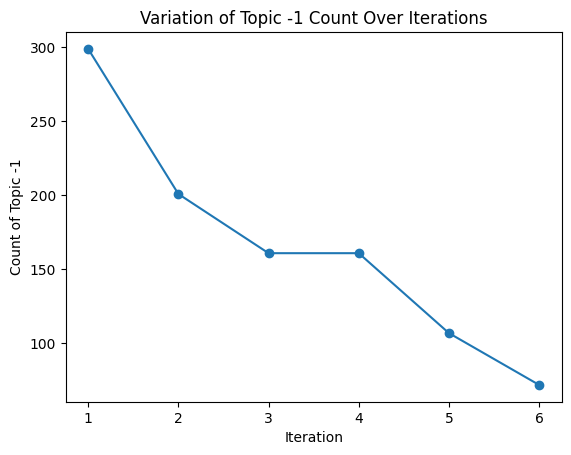

In [ ]:
#Set the number of iterations you want to track
num_iterations = 6

#Initialize a list to store the counts of '-1' in each iteration
cluster_counts = []

for iteration in range(1, num_iterations + 1):
    #Load data from the file
    file_path = f'outliers_iteration_{iteration}.csv'
    data = pd.read_csv(file_path)

    #Count occurrences of '-1' in the 'Cluster' column
    count_minus_1 = data['Topic'].eq(-1).sum()

    #Store the count in the list
    cluster_counts.append(count_minus_1)

#Plot the variation of counts at each iteration
plt.plot(range(1, num_iterations + 1), cluster_counts, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Count of Topic -1')
plt.title('Variation of Topic -1 Count Over Iterations')
plt.show()


This cell simply check the exact amount of abstracts for Topic -1. The desired iteration can be selected.

In [ ]:
#Replace 'outliers_iteration_n.csv' with the n-iteration you want to check
file_path = 'outliers_iteration_6.csv'
column_name = 'Topic'
topic = -1 #The topic in which we are interested

#Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_path)

#Count the occurrences of the specific value in the specified column
count_specific_value = (data[column_name] == topic).sum()

#Print the result
print(f'The number of occurrences of "{topic}" in column "{column_name}" is: {count_specific_value}')


FileNotFoundError: [Errno 2] No such file or directory: 'outliers_iteration_6.csv'

*   Convergence: It's possible that the clustering process is converging towards a stable solution, as the model iteratively updates cluster assignments outliers diminish.

*hint for future work*: If the decrease in outliers continues across iterations, it may indicate that the initial clustering had some noise or misclassifications, and the subsequent iterations are correcting or removing these cases. We are not investigating this specific aspect here, but future works should follow this direction by looking at the concrete results of each iteration.



## Evaluation


In this section, we conduct an evaluation of our topic modelling approach, using two key metrics: **topic coherence** and **topic diversity**. They provide indications of the quality and diversity of topics generated by our model.

TC: topic coherence.

This cell compute topic score coherence using BERT embeddings.This score indicates the coherence of the topics generated by our model based on the contextual similarity of words within each topic.
The score will be a numerical value indicating the coherence of the topics. the measure range from [-1,1] where 1 indicates a perfect association.

`Gensim` offers an implementation that makes TC relatively easy to calculate.

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

#Tokenize the abstracts
tokenized_abstracts = [abstract.split() for abstract in data_subset['abstract']]

#Create a gensim dictionary
dictionary = Dictionary(tokenized_abstracts)

#Initialize coherence model with the list of lists of top words and the dictionary
coherence_model = CoherenceModel(topics=top_words_per_topic, texts=tokenized_abstracts, dictionary=dictionary, coherence='c_v')

#Compute coherence score
coherence_score = coherence_model.get_coherence()
print(f"Topic Coherence Score: {coherence_score}")

Topic Coherence Score: 0.5024236336881484


TD: Topic Diversity.
Topic divesity will be computed to test how dissimilar the resulting topics are. The measure range from [0,1] where 0 indicates redundant topics and 1 indicates more varied topics. The TD we use is based on [Pairwise Jaccard Distance](https://https://link.springer.com/chapter/10.1007/978-3-642-40501-3_30)
(credits to https://github.com/silviatti/topic-model-diversity)


In [ ]:
#Import the combination function
from itertools import combinations

#Define a function for calculating pairwise JD
def pairwise_jaccard_diversity(topics):
    #Initialize the total Jaccard distance to 0
    dist = 0

    #initialize the count of pairwise combination 0
    count = 0

    #Iterates over all combinations of topics, calculating JD between pairs
    for list1, list2 in combinations(topics, 2):
        js = 1 - len(set(list1).intersection(set(list2)))/len(set(list1).union(set(list2)))
        dist = dist + js
        count = count + 1
    return dist/count

In [ ]:
topic_diversity = pairwise_jaccard_diversity(top_words_per_topic) #We recall the dict top_words_per_topic created above
print(f"Topic Diversity: {topic_diversity}")